### Env Setting

In [169]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.api as sm
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct
np.random.seed(42)

### Loading Taxi dataset

In [2]:
yellow = pd.read_csv("../Data/Taxi_Data/full_yellow.csv", index_col=0)
green = pd.read_csv("../Data/Taxi_Data/full_green.csv", index_col=0)
fhv = pd.read_csv("../Data/Taxi_Data/full_fhv.csv", index_col=0)
hvfhv = pd.read_csv("../Data/Taxi_Data/full_hvfhv.csv", index_col=0)
trad_taxi = yellow.append(green)
app_taxi = fhv.append(hvfhv)
total_taxi = trad_taxi.append(app_taxi)

In [3]:
yellow.index = pd.to_datetime(yellow.index)
green.index = pd.to_datetime(green.index)
fhv.index = pd.to_datetime(fhv.index)
hvfhv.index = pd.to_datetime(hvfhv.index)
trad_taxi.index = pd.to_datetime(trad_taxi.index)
app_taxi.index = pd.to_datetime(app_taxi.index)
total_taxi.index = pd.to_datetime(total_taxi.index)

### Plotting - Raw Data

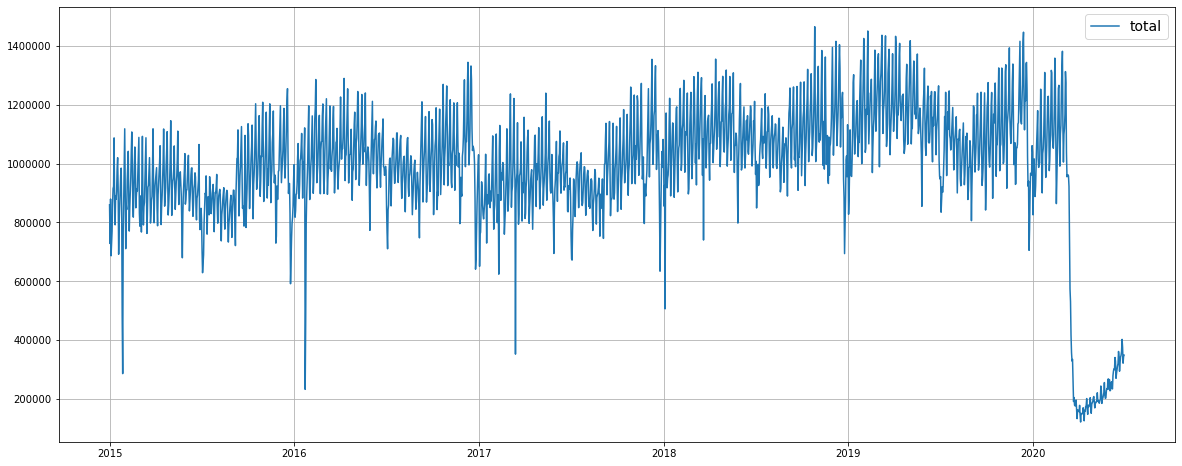

In [4]:
################################################
# 'individual': yellow / green / fhv / hvfhv
# 'twoGroup':   yellow + green / fhv + hvfhv
# 'total':      yellow + green + fhv + hvfhv
################################################
plot_type = 'total'    

plt.figure(figsize=(20,8))
if plot_type == 'individual': 
    plt.plot(yellow['passenger_count'].groupby(yellow.index).sum(), label="yellow")
    plt.plot(green['passenger_count'].groupby(green.index).sum(), label="green")
    plt.plot(fhv['passenger_count'].groupby(fhv.index).sum(), label="fhv")
    plt.plot(hvfhv['passenger_count'].groupby(hvfhv.index).sum(), label="hvfhv")
elif plot_type == 'twoGroup':
    plt.plot(trad_taxi['passenger_count'].groupby(trad_taxi.index).sum(), label="yellow + green", c="darkorange")
    plt.plot(app_taxi['passenger_count'].groupby(app_taxi.index).sum(), label="fhv (including high volume)")
elif plot_type == 'total':
    plt.plot(total_taxi['passenger_count'].groupby(total_taxi.index).sum(), label="total")

plt.legend(fontsize=14)
plt.grid()
plt.show()

### Split into preCovid_training / preCovid_test / postCovid

In [5]:
# preCovid // postCovid
total = total_taxi['passenger_count'].groupby(total_taxi.index).sum()
covidOutbreak = '2020-03-01'
preCovid = total.loc[:covidOutbreak]
postCovid = total.loc[covidOutbreak:]

In [6]:
# training // test 
trainCutoff = '2019-01-01'
train = preCovid[:trainCutoff]
test = preCovid[trainCutoff:]

### Plotting ACF, PACF

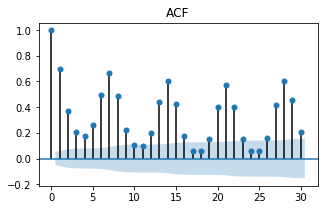

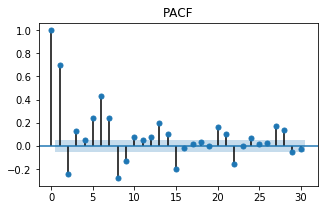

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 3
lag = len(train) -1
plot_acf(x=train, lags=30, title='ACF')  ## ACF plots shows strong seasonality
plt.show()
plot_pacf(x=train, lags=30, title='PACF')
plt.show()

### Seasonal Decomposition

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


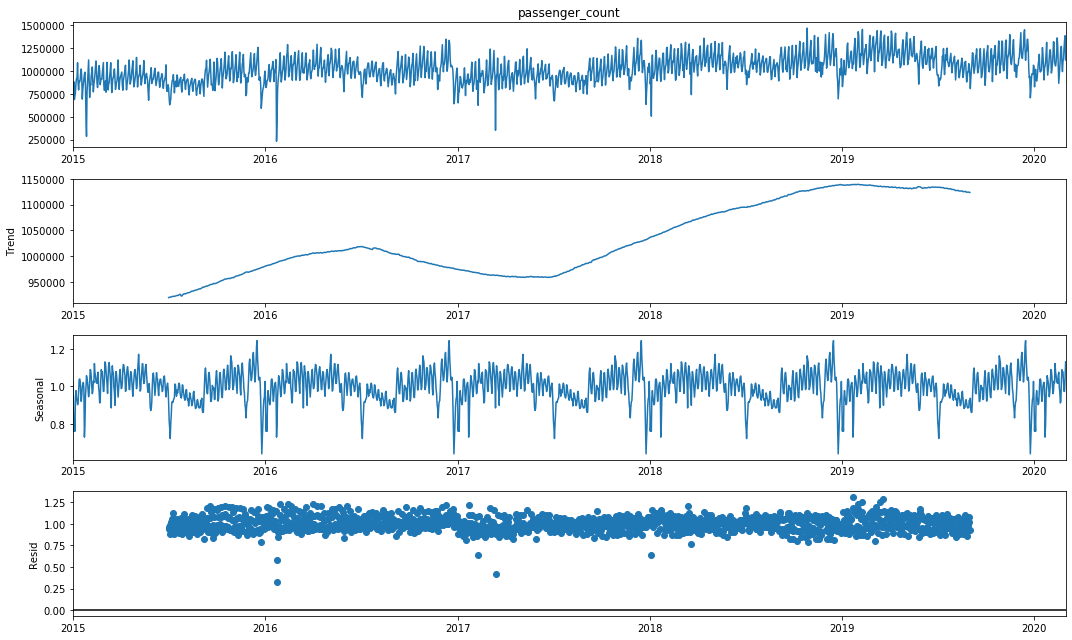

In [8]:
# https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/
rcParams['figure.figsize'] = 15, 9
preCovid_decompose = seasonal_decompose(preCovid, model='multiplicative', freq=365)
preCovid_decompose.plot()
plt.show()

In [9]:
pd.DataFrame({"observed": preCovid_decompose.observed, "trend": preCovid_decompose.trend, \
              "seasonal": preCovid_decompose.seasonal, "resid": preCovid_decompose.resid, \
              "multiplied": preCovid_decompose.trend*preCovid_decompose.seasonal*preCovid_decompose.resid})[182:-182]

,observed,trend,seasonal,resid,multiplied
pickup_datetime,,,,,
2015-07-02,811065.0,9.202151e+05,0.912593,0.965804,811065.0
2015-07-03,704873.0,9.205889e+05,0.818359,0.935624,704873.0
2015-07-04,629107.0,9.209550e+05,0.779229,0.876640,629107.0
2015-07-05,657374.0,9.207854e+05,0.723349,0.986975,657374.0
2015-07-06,689705.0,9.212056e+05,0.799302,0.936690,689705.0
...,...,...,...,...,...
2019-08-28,987570.0,1.123892e+06,0.885434,0.992401,987570.0
2019-08-29,988803.0,1.123925e+06,0.891859,0.986453,988803.0
2019-08-30,1077973.0,1.124064e+06,0.887162,1.080971,1077973.0


In [10]:
preCovid_resid = preCovid_decompose.resid[182:-182]
train_resid = preCovid_resid[:trainCutoff]
test_resid = preCovid_resid[trainCutoff:]

### Normalization

In [11]:
# scaler = StandardScaler()
# scaler.fit(train_resid.values.reshape(-1,1))
# train = scaler.transform(train_resid.values.reshape(-1,1))
# test = scaler.transform(test.values.reshape(-1,1))

### Fitting ARIMA

In [12]:
import warnings
warnings.filterwarnings("ignore")
mse_list = []
for i in range(10):
    arima = ARIMA(train_resid, order=(i,0,0), freq='D')
    arima_res = arima.fit()
    mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
    print(f'>>> p = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

>>> p = 0, mean_squared_error: 0.006907029522458884
>>> p = 1, mean_squared_error: 0.0057928050486184424
>>> p = 2, mean_squared_error: 0.00522005318210537
>>> p = 3, mean_squared_error: 0.005215542935446746
>>> p = 4, mean_squared_error: 0.005072161794357472
>>> p = 5, mean_squared_error: 0.005064554647558224
>>> p = 6, mean_squared_error: 0.004518751746315025
>>> p = 7, mean_squared_error: 0.003963471452940985
>>> p = 8, mean_squared_error: 0.003934326774130549
>>> p = 9, mean_squared_error: 0.0038859650921446317


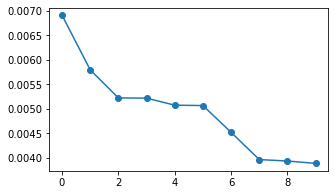

Plateau around p=7


In [13]:
plt.figure(figsize=(5,3))
plt.plot(mse_list, marker='o')
plt.show()
print("Plateau around p=7")

In [14]:
ma_mse_list = []
for i in range(10):
    arima = ARIMA(train_resid, order=(7,0,i), freq='D')
    arima_res = arima.fit()
    ma_mse_list.append(mean_squared_error(train_resid, arima_res.fittedvalues))
    print(f'>>> q = {i}, mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

>>> q = 0, mean_squared_error: 0.003963471452940985
>>> q = 1, mean_squared_error: 0.003945985356646978
>>> q = 2, mean_squared_error: 0.0038983629190704875
>>> q = 3, mean_squared_error: 0.003910257344476881
>>> q = 4, mean_squared_error: 0.0033282031820600034
>>> q = 5, mean_squared_error: 0.0032802216919847736
>>> q = 6, mean_squared_error: 0.0033812783882682202
>>> q = 7, mean_squared_error: 0.0032740737157763615
>>> q = 8, mean_squared_error: 0.003211285760427847
>>> q = 9, mean_squared_error: 0.0031893138360845246


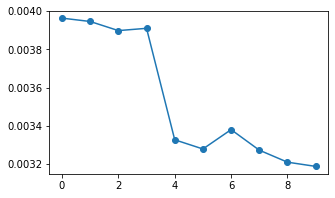

Plateau around p=4


In [15]:
plt.figure(figsize=(5,3))
plt.plot(ma_mse_list, marker='o')
plt.show()
print("Plateau around p=4")

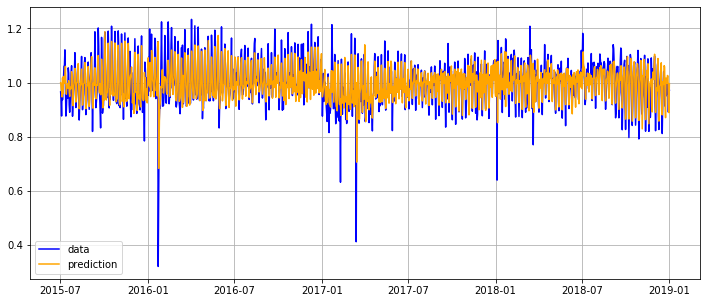

>>> mean_squared_error: 0.0033282031820600034


In [16]:
arima = ARIMA(train_resid, order=(7,0,4), freq='D')
arima_res = arima.fit()
plt.figure(figsize=(12,5))
plt.plot(train_resid, color='blue', label="data")
plt.plot(arima_res.fittedvalues, color='orange', label="prediction")
plt.legend()
plt.grid()
plt.show()
print(f'>>> mean_squared_error: {mean_squared_error(train_resid, arima_res.fittedvalues)}')

In [17]:
pred = arima_res.predict(start='2019-01-01', end='2019-09-01')  # excluding NaN
print(f'Test set MSE: {mean_squared_error(test_resid, pred)}')

Test set MSE: 0.006830672575370352


In [19]:
post_resid_pred = arima_res.predict(start='2020-03-01', end='2020-06-30')
last_trend = preCovid_decompose.trend[-183]
last_seasonality = preCovid_decompose.seasonal['2019-03-03':'2019-07-02'].values
post_pred = last_trend * last_seasonality * post_resid_pred
pd.DataFrame({'trend': last_trend, 'seasonal': last_seasonality, 'resid': post_resid_pred, 'prediction': post_pred})

,trend,seasonal,resid,prediction
2020-03-01,1.123440e+06,1.123601,0.996444,1.257810e+06
2020-03-02,1.123440e+06,1.088022,0.997557,1.219341e+06
2020-03-03,1.123440e+06,1.059012,1.002988,1.193292e+06
2020-03-04,1.123440e+06,1.009875,0.999032,1.133437e+06
2020-03-05,1.123440e+06,0.963127,0.995549,1.077200e+06
...,...,...,...,...
2020-06-26,1.123440e+06,1.003923,1.000778,1.128726e+06
2020-06-27,1.123440e+06,1.017459,1.001402,1.144657e+06
2020-06-28,1.123440e+06,0.989358,0.997556,1.108768e+06
2020-06-29,1.123440e+06,0.912593,0.998567,1.023774e+06


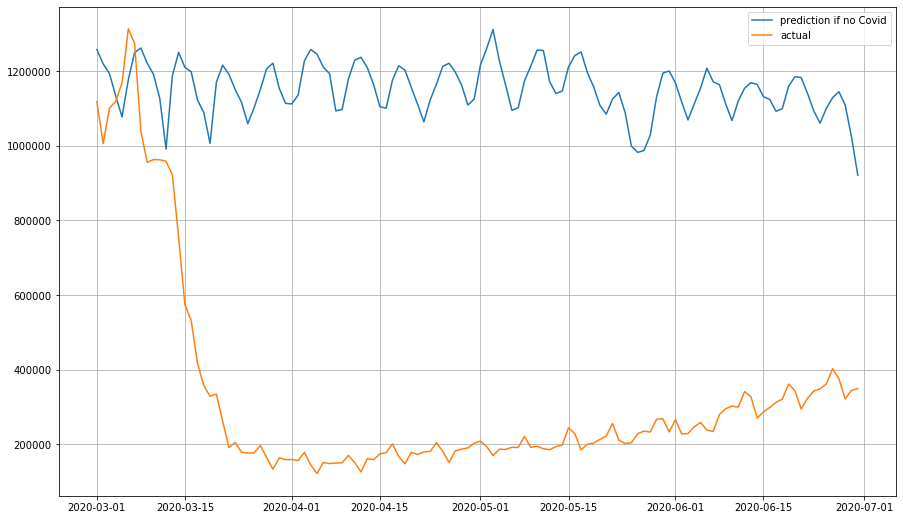

PostCovid MSE: 757401340001.808


In [20]:
plt.plot(post_pred, label="prediction if no Covid")
plt.plot(postCovid, label="actual")
plt.legend()
plt.grid()
plt.show()
print(f'PostCovid MSE: {mean_squared_error(postCovid, post_pred)}')

### Kalman Filtering

In [22]:
def plot_kalman(time, latent, data, ky=None, ky_var=None, plot_type="r-", label=None, title='sample'):
    """
    Plot the trajectory
    """
    x, y = time, latent
    nx, ny = data[:, 0], data[:, 1]
    fig, ax = plt.subplots(1, 2, figsize=(18, 4))
    if ky is not None:
        ax[0].plot(x, y, 'g-', time, nx, 'b.', time, ny, 'b.', time, ky, 'r-', plot_type)
        if ky_var is not None:
            ax[0].fill_between(time, ky - np.sqrt(ky_var),
                               ky + np.sqrt(ky_var), color='r', alpha=.5, label='estimate')
        ax[0].legend()
        ax[1].plot(y, ky, '.', color='grey')
        ax[1].set_xlabel('real latent')
        ax[1].set_ylabel('estimated latent')
        ax[1].set_title('cc %.3f' %(np.corrcoef(y[:,0], ky)[0,1]))
    else:
        ax[0].plot(x, y, 'g-', x, nx, 'b.', x, ny, 'b.')

        ax[1].plot(y, nx, '.k', label='observed dim 1')
        ax[1].plot(y, ny, '.', color='grey', label='observed dim 2')
        ax[1].set_xlabel('latent')
        ax[1].set_ylabel('observed')
        ax[1].legend()

    ax[0].set_xlabel('time')
    ax[0].set_ylabel('latent')
    ax[0].set_title(title)
    ax[1].set_aspect(1)

    return fig

In [123]:
n_dim_state = 1
n_dim_obs = 1
kf_daily = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                        transition_matrices = np.eye(n_dim_state)*.9, 
                        transition_covariance = np.eye(n_dim_state)*10, 
                        observation_matrices = np.random.randn(n_dim_state*n_dim_obs).reshape(n_dim_obs, n_dim_state),
                        observation_covariance = np.eye(n_dim_obs)*10,
                        initial_state_mean = np.zeros(n_dim_state), 
                        initial_state_covariance = np.eye(n_dim_state),
                        random_state=42)
kf_daily = kf_daily.em(train_resid, n_iter=50, em_vars='all')

In [124]:
filtered_mean, filtered_cov = kf_daily.filter(train_resid)
smoothed_mean, smoothed_cov = kf_daily.smooth(train_resid)

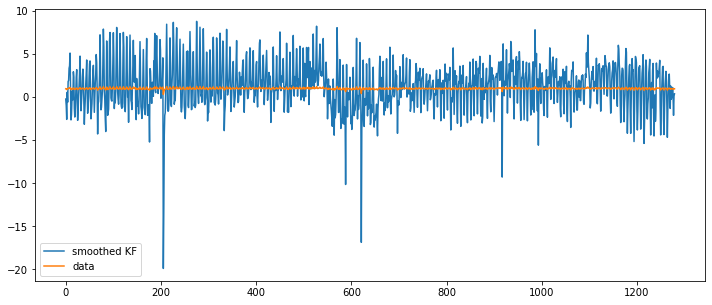

In [125]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean, label="smoothed KF")
# plt.plot(filtered_mean, label="filtered KF")
plt.plot(train_resid.values, label="data")
plt.legend()
plt.show()

### Kalman Filtering w/o Outliers

In [68]:
# Removing outliers
outliers = ['2016-01-23', '2017-03-14']
print(f'outlier: {outliers[0]}, {train_resid[outliers[0]]}')
print(f'outlier: {outliers[1]}, {train_resid[outliers[1]]}')

train_resid_wo_outliers = train_resid.copy()
train_resid_wo_outliers[outliers[0]] = (train_resid_wo_outliers['2016-01-22'] + train_resid_wo_outliers['2016-01-24']) / 2
train_resid_wo_outliers[outliers[1]] = (train_resid_wo_outliers['2017-03-13'] + train_resid_wo_outliers['2017-03-15']) / 2

outlier: 2016-01-23, 0.32176172828155447
outlier: 2017-03-14, 0.41285642948057244


In [126]:
n_dim_state = 1
n_dim_obs = 1
kf_daily_wo_outliers = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                          transition_matrices = np.eye(n_dim_state)*.9, 
                          transition_covariance = np.eye(n_dim_state)*10, 
                          observation_matrices = np.random.randn(n_dim_state*n_dim_obs).reshape(n_dim_obs, n_dim_state),
                          observation_covariance = np.eye(n_dim_obs)*10,
                          initial_state_mean = np.zeros(n_dim_state), 
                          initial_state_covariance = np.eye(n_dim_state),
                          random_state=42)
kf_daily_wo_outliers = kf_daily_wo_outliers.em(train_resid_wo_outliers, n_iter=50, em_vars='all')

In [127]:
filtered_mean_wo_outliers, filtered_cov_wo_outliers = kf_daily_wo_outliers.filter(train_resid_wo_outliers)
smoothed_mean_wo_outliers, smoothed_cov_wo_outliers = kf_daily_wo_outliers.smooth(train_resid_wo_outliers)

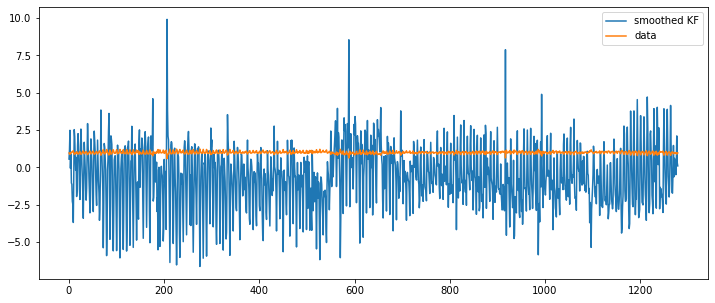

In [128]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean_wo_outliers, label="smoothed KF")
# plt.plot(filtered_mean_wo_outliers, label="filtered KF")
plt.plot(train_resid_wo_outliers.values, label="data")
plt.legend()
plt.show()

### Kalman Filter - Using Original Data (not residual)

In [186]:
n_dim_state = 1
n_dim_obs = 1
kf_daily_orig = KalmanFilter(n_dim_state=n_dim_state, n_dim_obs=n_dim_obs, 
                  transition_matrices = np.eye(n_dim_state), 
                  transition_covariance = np.eye(n_dim_state), 
                  observation_matrices = np.eye(n_dim_obs, n_dim_state),
                  observation_covariance = np.eye(n_dim_obs),
                  initial_state_mean = np.zeros(n_dim_state), 
                  initial_state_covariance = np.eye(n_dim_state),
                  random_state=42)
kf_daily_orig = kf_daily_orig.em(train, n_iter=5, em_vars='all')

In [187]:
filtered_mean_orig, filtered_cov_orig = kf_daily_orig.filter(train)
smoothed_mean_orig, smoothed_cov_orig = kf_daily_orig.smooth(train)

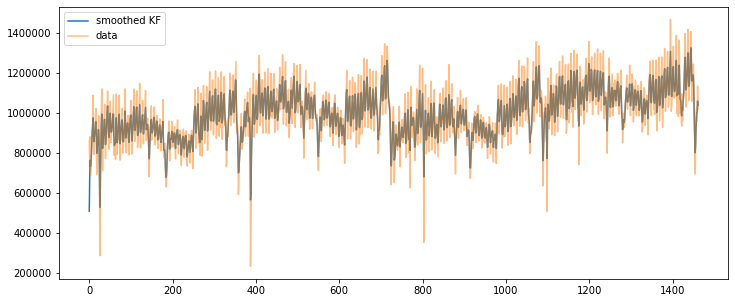

>>> train mean_squared_error: 2372576940.7931824


In [234]:
plt.figure(figsize=(12,5))
plt.plot(smoothed_mean_orig, label="smoothed KF")
# plt.plot(filtered_mean_orig, label="filtered KF")
plt.plot(train.values, label="data", alpha=0.5)
plt.legend()
plt.show()
print(f'>>> train mean_squared_error: {mean_squared_error(preCovid.values[:len(train)], smoothed_mean_orig[:len(train)])}')

In [199]:
A = kf_daily_orig.transition_matrices.reshape(-1)
Q = kf_daily_orig.transition_covariance.reshape(-1)
C = kf_daily_orig.observation_matrices.reshape(-1)
R = kf_daily_orig.observation_covariance.reshape(-1)

In [244]:
np.random.seed(seed=42)
latent_pred = [float(smoothed_mean_orig[-1])]
for i in range(len(test)):
    next_latent = latent_pred[-1] * A + np.random.normal(0, np.sqrt(Q), 1)
    latent_pred.append(float(next_latent))
    
obs_pred = []
for i in range(len(test)):
    next_obs = latent_pred[i+1] * C + np.random.normal(0, np.sqrt(R), 1)
    obs_pred.append(float(next_obs))

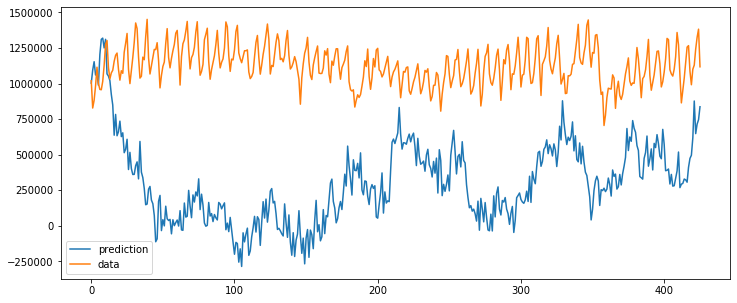

>>> test_ mean_squared_error: 799232576740.2101


In [245]:
plt.figure(figsize=(12,5))
plt.plot(obs_pred, label="prediction")
plt.plot(test.values, label="data")
plt.legend()
plt.show()
print(f'>>> test_mean_squared_error: {mean_squared_error(test.values, obs_pred)}')

In [260]:
np.random.seed(seed=42)
postCovid_latent_pred = [float(test.values[-1])]
for i in range(len(postCovid)):
    next_latent = postCovid_latent_pred[-1] * A + np.random.normal(0, np.sqrt(Q), 1)
    postCovid_latent_pred.append(float(next_latent))
    
postCovid_obs_pred = []
for i in range(len(postCovid)):
    next_obs = postCovid_latent_pred[i+1] * C + np.random.normal(0, np.sqrt(R), 1)
    postCovid_obs_pred.append(float(next_obs))

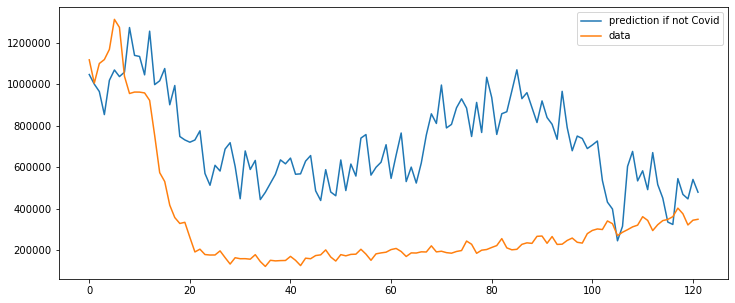

>>> postCovid_mean_squared_error: 208462261258.06796


In [261]:
plt.figure(figsize=(12,5))
plt.plot(postCovid_obs_pred, label="prediction if not Covid")
plt.plot(postCovid.values, label="data")
plt.legend()
plt.show()
print(f'>>> postCovid_mean_squared_error: {mean_squared_error(postCovid.values, postCovid_obs_pred)}')

### Gaussian Process

In [ ]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None, ax=None, legendon=True):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        ax.plot(x_pred.reshape(-1, 1), samples)
    
    ax.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                 label="pred mean")
    ax.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        ax.plot(x_pred, true_y, "b-", label="ground truth")
    if legendon: ax.legend()

In [ ]:
traintime = np.arange(len(train))
predtime = np.arange(len(preCovid))
true_y = preCovid.values

kernel = RBF() + ExpSineSquared()*DotProduct() + ConstantKernel(constant_value=2)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), train.values.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(predtime, mus, sigmas, traintime, train.values, true_y, ax=ax)
plt.grid()
print("mse = {0}".format((mean_squared_error(mus, true_y))))